In [1]:
%run C:/Users/FinLab615_83/Desktop/捷智計畫/MetaEdge/function.ipynb

# load data

In [2]:
PATH = 'C:/Users/FinLab615_83/Desktop/捷智計畫/MetaEdge/'
FILE = 'TWN_A11_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv'
df = pd.read_csv(PATH + FILE)
df.columns

Index(['alert_id', 'run_date', 'primary_entity_level_code',
       'primary_entity_number', 'scenario_name', 'TO_SAR', 'Acct_No',
       'Cust_No', 'Cust_Key', 'Cust_Segmentation', 'Cust_Typ_Cd', 'Cust_Id_Id',
       'Cust_Id_Typ_Desc', 'Cust_Id_State_Cd', 'Cust_Dt_Of_Birth',
       'Cust_Sts_Desc', 'Street_Postal_Cd', 'Street_Cntry_Cd',
       'Mailing_Postal_Cd', 'Mailing_Cntry_Cd', 'Residence_Cntry_Cd',
       'Citizenship_Cntry_Cd', 'Org_Cntry_Of_Buz_Cd', 'Empl_No', 'Ocup_Code',
       'job_title_code', 'Lst_Cont_Dt', 'Politically_Exposed_Pers_Ind',
       'Non_Prft_Org_Ind', 'Cust_Since_Dt', 'Lst_Susp_Actv_Rpt_Dt',
       'Extnl_Cust_Ind', 'Negative_News_Ind', 'Prim_Br_No', 'Obu_Ind',
       'Riskclass_Cd', 'risk_score', 'last_risk_assessment_date',
       'change_current_ind', 'change_begin_date', 'change_end_date',
       'Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit'],
      dtype='object')

In [3]:
df['TO_SAR'] = df['TO_SAR'].replace(np.nan, 0)
df['TO_SAR'] = df['TO_SAR'].replace('F', 1)
df['TO_SAR'] = df['TO_SAR'].replace('NF', 1)

In [4]:
df['TO_SAR'].value_counts()

0    86324
1      446
Name: TO_SAR, dtype: int64

In [5]:
SAR_type = 'TO_SAR'
train_set, test_set = ReadFile(df, SAR_type)

Verify on time series
shape of data: (86770, 39)
total number of TO_SAR: 446
********************************
time interval in train set:2019-03-04~2020-04-29
TO_SAR in train set: 267
TO_SAR/Total in train set 0.005128599143312653
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 179
TO_SAR/Total in test set 0.0051571638479933155
********************************
train data shape:  (52061, 38)
test data shape:  (34709, 38)


In [6]:
train_set = train_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']).reset_index(drop= True)
test_set = test_set.dropna(subset= ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']).reset_index(drop= True)
print(f'train_set:{train_set.shape}\n' + f'test_set:{test_set.shape}')

train_set:(52060, 38)
test_set:(34709, 38)


# Active Learning

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from modAL.models import ActiveLearner
from modAL.batch import uncertainty_batch_sampling
from functools import partial
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from xgboost import XGBClassifier

In [25]:
SEED = 1129
np.random.seed(SEED)

In [26]:
X_train_raw = train_set[['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']]
X_test_raw = test_set[['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']]
y_train_raw = train_set['TO_SAR']
y_test_raw = test_set['TO_SAR']

In [27]:
# MinMaxScaler
scaler = MinMaxScaler()
X_train_transformed = scaler.fit_transform(X_train_raw)
x_test_transformed = scaler.transform(X_test_raw)

In [28]:
# initial train data
INITIAL_SIZE = 10
initial_index = np.random.randint(low= 0, high= X_train_transformed.shape[0] + 1, size= INITIAL_SIZE)
X_train = X_train_transformed[initial_index]
y_train = y_train_raw[initial_index].to_numpy()
print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}')

X_train shape: (10, 4)
y_train shape: (10,)


In [29]:
# generate the pool
X_pool = np.delete(X_train_transformed, initial_index, axis= 0)
y_pool = np.delete(y_train_raw.to_numpy(), initial_index, axis= 0)
print(f'X_pool shape: {X_pool.shape}', '\n' f'y_pool shape: {y_pool.shape}')

X_pool shape: (52050, 4) 
y_pool shape: (52050,)


In [30]:
X_pool1 = deepcopy(X_pool)
y_pool1 = deepcopy(y_pool)

In [31]:
clf_RF = RandomForestClassifier(n_estimators= 100, n_jobs= -1)
clf_XGB = XGBClassifier(n_estimators= 100, gpu_id= 0, n_jobs= -1)

In [32]:
BATCH_SIZE = 100
pre_fetch = partial(uncertainty_batch_sampling, n_instances= BATCH_SIZE)

In [33]:
#N_QUERIES = len(X_pool) // BATCH_SIZE
N_QUERIES = 1000 // BATCH_SIZE
N_QUERIES

10

## Random Forest and Random sampling

In [17]:
# initializing the active learner
learner = ActiveLearner(
    estimator= clf_RF,
    query_strategy= pre_fetch,
    X_training= X_train, y_training= y_train
)


In [18]:
learner_list = [
    (0, learner, X_pool, y_pool),
    (1, deepcopy(learner), X_pool1, y_pool1)
]

In [19]:
performance_history= list()
for member_idx, learner, X_pool, y_pool in learner_list:
    print(f'learner{member_idx}')
    tmp_performance_history = list()
    for index in range(N_QUERIES):
        if member_idx == 0:
            query_index, query_instance = learner.query(X_pool)
            X, y = X_pool[query_index], y_pool[query_index]
            learner.teach(X= X, y= y)
            X_pool = np.delete(X_pool, query_index, axis= 0)
            y_pool = np.delete(y_pool, query_index, axis= 0)
        else:
            query_index = np.random.randint(low= 0, high= len(X_pool1), size= BATCH_SIZE)
            X, y = X_pool1[query_index], y_pool1[query_index]
            learner.teach(X= X, y= y)
            X_pool1 = np.delete(X_pool1, query_index, axis= 0)
            y_pool1 = np.delete(y_pool1, query_index, axis= 0)

        # Calculate the queried instance from the unlabel pool

        model_accuracy = learner.score(X_train_transformed, y_train_raw)
        print(f'Accuracy after query {index + 1}: {model_accuracy:0.7f}')
        tmp_performance_history.append(model_accuracy)
    performance_history.append(tmp_performance_history)

learner0
Accuracy after query 1: 0.9949481
Accuracy after query 2: 0.9949673
Accuracy after query 3: 0.9949673
Accuracy after query 4: 0.9950634
Accuracy after query 5: 0.9951018
Accuracy after query 6: 0.9951210
Accuracy after query 7: 0.9952171
Accuracy after query 8: 0.9952555
Accuracy after query 9: 0.9952939
Accuracy after query 10: 0.9953131
learner1
Accuracy after query 1: 0.9948713
Accuracy after query 2: 0.9948713
Accuracy after query 3: 0.9947176
Accuracy after query 4: 0.9948713
Accuracy after query 5: 0.9948713
Accuracy after query 6: 0.9947753
Accuracy after query 7: 0.9947753
Accuracy after query 8: 0.9942758
Accuracy after query 9: 0.9941222
Accuracy after query 10: 0.9942182


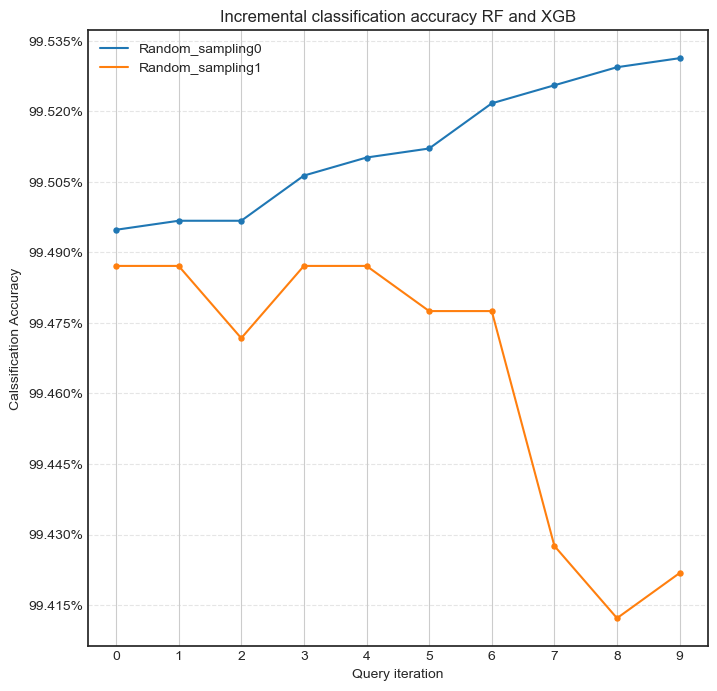

In [20]:
# Plot our performance over time.
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize= (8, 8))
    for member_idx , *_ in learner_list: 
        ax.plot(performance_history[member_idx], label= f'Random_sampling{member_idx}')
        ax.scatter(range(len(performance_history[member_idx])), performance_history[member_idx], s= 13)
    
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins= N_QUERIES+3, integer= True))
    ax.xaxis.grid(True)

    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins= 10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax= 1))
    #ax.set_ylim(bottom= 0, top= 1)
    ax.yaxis.grid(True, linestyle= '--', alpha= 0.5)

    ax.set_title('Incremental classification accuracy RF and XGB')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Calssification Accuracy')
    ax.legend()

    plt.show()

## Random Forest and XGBoost

In [34]:
# initializing the active learner
learner = ActiveLearner(
    estimator= clf_RF,
    query_strategy= pre_fetch,
    X_training= X_train, y_training= y_train
)

learner1 = ActiveLearner(
    estimator= clf_XGB,
    query_strategy= pre_fetch,
    X_training= X_train, y_training= y_train
)

In [35]:
learner_list = [
    (0, learner, X_pool, y_pool),
    (1, learner1, X_pool1, y_pool1)
]

In [36]:
performance_history= list()
for member_idx, learner, X_pool, y_pool in learner_list:
    print(f'learner{member_idx}')
    tmp_performance_history = list()
    for index in range(N_QUERIES):
        if member_idx == 0:
            query_index, query_instance = learner.query(X_pool)
            X, y = X_pool[query_index], y_pool[query_index]
            learner.teach(X= X, y= y)
            X_pool = np.delete(X_pool, query_index, axis= 0)
            y_pool = np.delete(y_pool, query_index, axis= 0)
        else:
            #query_index = np.random.randint(low= 0, high= len(X_pool1), size= BATCH_SIZE)
            query_index, query_instance = learner.query(X_pool1)
            X, y = X_pool1[query_index], y_pool1[query_index]
            learner.teach(X= X, y= y)
            X_pool1 = np.delete(X_pool1, query_index, axis= 0)
            y_pool1 = np.delete(y_pool1, query_index, axis= 0)

        # Calculate the queried instance from the unlabel pool

        model_accuracy = learner.score(X_train_transformed, y_train_raw)
        print(f'Accuracy after query {index + 1}: {model_accuracy:0.7f}')
        tmp_performance_history.append(model_accuracy)
    performance_history.append(tmp_performance_history)

learner0
Accuracy after query 1: 0.9949481
Accuracy after query 2: 0.9949673
Accuracy after query 3: 0.9949673
Accuracy after query 4: 0.9950634
Accuracy after query 5: 0.9951018
Accuracy after query 6: 0.9951210
Accuracy after query 7: 0.9952171
Accuracy after query 8: 0.9952555
Accuracy after query 9: 0.9952939
Accuracy after query 10: 0.9953131
learner1
Accuracy after query 1: 0.9948713
Accuracy after query 2: 0.9948713
Accuracy after query 3: 0.9941222
Accuracy after query 4: 0.9950442
Accuracy after query 5: 0.9950442
Accuracy after query 6: 0.9950826
Accuracy after query 7: 0.9950826
Accuracy after query 8: 0.9951594
Accuracy after query 9: 0.9951786
Accuracy after query 10: 0.9951978


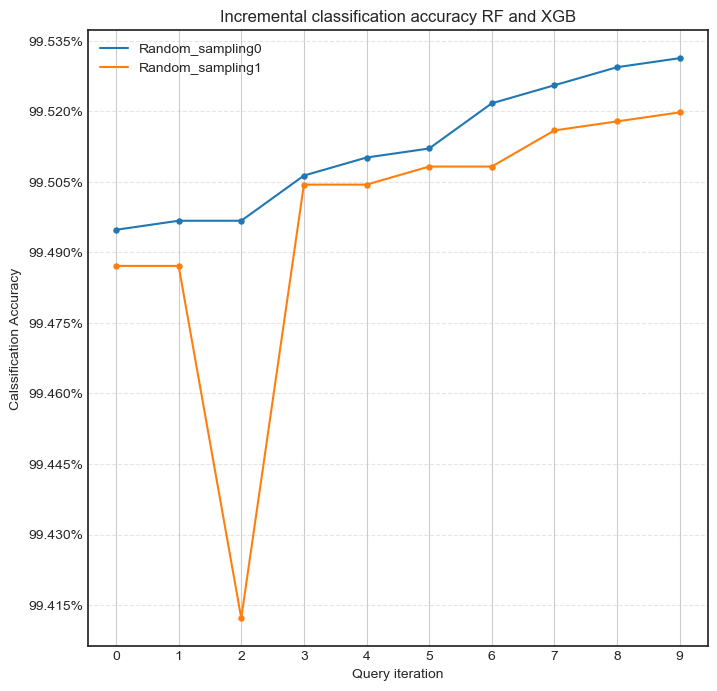

In [37]:
# Plot our performance over time.
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(figsize= (8, 8))
    for member_idx , *_ in learner_list: 
        ax.plot(performance_history[member_idx], label= f'Random_sampling{member_idx}')
        ax.scatter(range(len(performance_history[member_idx])), performance_history[member_idx], s= 13)
    
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins= N_QUERIES+3, integer= True))
    ax.xaxis.grid(True)

    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins= 10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax= 1))
    #ax.set_ylim(bottom= 0, top= 1)
    ax.yaxis.grid(True, linestyle= '--', alpha= 0.5)

    ax.set_title('Incremental classification accuracy RF and XGB')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Calssification Accuracy')
    ax.legend()

    plt.show()